

# Tutorial 3: Train SimCLR on Clothing

In this tutorial, we will train a SimCLR model using lightly. The model,
augmentations and training procedure is from 
[A Simple Framework for Contrastive Learning of Visual Representations](https://arxiv.org/abs/2002.05709).

The paper explores a rather simple training procedure for contrastive learning.
Since we use the typical contrastive learning loss based on NCE the method
greatly benefits from having larger batch sizes. In this example, we use a batch
size of 256 and paired with the input resolution per image of 64x64 pixels and
a resnet-18 model this example requires 16GB of GPU memory.

We use the 
[clothing dataset from Alex Grigorev](https://github.com/alexeygrigorev/clothing-dataset) 
for this tutorial.

In this tutorial you will learn:

- How to create a SimCLR model

- How to generate image representations

- How different augmentations impact the learned representations


## Imports

Import the Python frameworks we need for this tutorial.



In [5]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from lightly.data import LightlyDataset
from lightly.transforms import SimCLRTransform, utils


## Configuration

We set some configuration parameters for our experiment.
Feel free to change them and analyze the effect.

The default configuration with a batch size of 256 and input resolution of 128
requires 6GB of GPU memory.



In [2]:
num_workers = 8
batch_size = 256
seed = 1
max_epochs = 20
input_size = 128
num_ftrs = 32

Let's set the seed for our experiments



In [3]:
pl.seed_everything(seed)

Seed set to 1


1

Make sure `path_to_data` points to the downloaded clothing dataset.
You can download it using
`git clone https://github.com/alexeygrigorev/clothing-dataset.git`



In [4]:
path_to_data =  "C:\\Users\\ROG ZEPHYRUS\\Desktop\\clothesclass\\images_original"

In [6]:
import pandas as pd
data=pd.read_csv("images.csv")
data

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False
3,ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa,43,T-Shirt,False
4,3b86d877-2b9e-4c8b-a6a2-1d87513309d0,189,Shoes,False
...,...,...,...,...
5398,dfd4079d-967b-4b3e-8574-fbac11b58103,204,Shorts,False
5399,befa14be-8140-4faf-8061-1039947e329d,204,Body,True
5400,5379356a-40ee-4890-b416-2336a7d84061,310,Shorts,False
5401,65507fb8-3456-4c15-b53e-d1b03bf71a59,204,Shoes,False


## Setup data augmentations and loaders

The images from the dataset have been taken from above when the clothing was
on a table, bed or floor. Therefore, we can make use of additional augmentations
such as vertical flip or random rotation (90 degrees).
By adding these augmentations we learn our model invariance regarding the
orientation of the clothing piece. E.g. we don't care if a shirt is upside down
but more about the strcture which make it a shirt.

You can learn more about the different augmentations and learned invariances
here: `lightly-advanced`.



In [7]:


transform = SimCLRTransform(input_size=input_size, vf_prob=0.5, rr_prob=0.5)

# We create a torchvision transformation for embedding the dataset after
# training
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=utils.IMAGENET_NORMALIZE["mean"],
            std=utils.IMAGENET_NORMALIZE["std"],
        ),
    ]
)

dataset_train_simclr = LightlyDataset(input_dir=path_to_data, transform=transform)

dataset_test = LightlyDataset(input_dir=path_to_data, transform=test_transform)

dataloader_train_simclr = torch.utils.data.DataLoader(
    dataset_train_simclr,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

## Create the SimCLR Model
Now we create the SimCLR model. We implement it as a PyTorch Lightning Module
and use a ResNet-18 backbone from Torchvision. Lightly provides implementations
of the SimCLR projection head and loss function in the `SimCLRProjectionHead`
and `NTXentLoss` classes. We can simply import them and combine the building
blocks in the module.



In [8]:
from lightly.loss import NTXentLoss
from lightly.models.modules.heads import SimCLRProjectionHead


class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

Train the module using the PyTorch Lightning Trainer on a single GPU.



In [9]:
import pytorch_lightning as pl



model = SimCLRModel()
trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="cpu")
trainer.fit(model, dataloader_train_simclr)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated model params size (MB)
c:\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\Python312\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower valu

Epoch 1:  18%|█▊        | 4/22 [02:45<12:22,  0.02it/s, v_num=6] 

In [9]:
torch.cuda.is_available()

False

Next we create a helper function to generate embeddings
from our test images using the model we just trained.
Note that only the backbone is needed to generate embeddings,
the projection head is only required for the training.
Make sure to put the model into eval mode for this part!



In [10]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, _, fnames in dataloader:
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames


model.eval()
embeddings, filenames = generate_embeddings(model, dataloader_test)

## Visualize Nearest Neighbors
Let's look at the trained embedding and visualize the nearest neighbors for
a few random samples.

We create some helper functions to simplify the work



In [11]:
def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array"""
    img = Image.open(filename)
    return np.asarray(img)


def plot_knn_examples(embeddings, filenames, n_neighbors=3, num_examples=6):
    """Plots multiple rows of random images with their nearest neighbors"""
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get 5 random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(path_to_data, filenames[neighbor_idx])
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f"d={distances[idx][plot_x_offset]:.3f}")
            # let's disable the axis
            plt.axis("off")

Let's do the plot of the images. The leftmost image is the query image whereas
the ones next to it on the same row are the nearest neighbors.
In the title we see the distance of the neigbor.



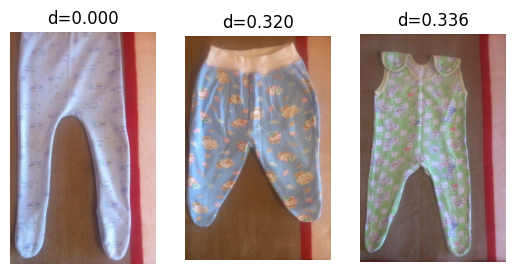

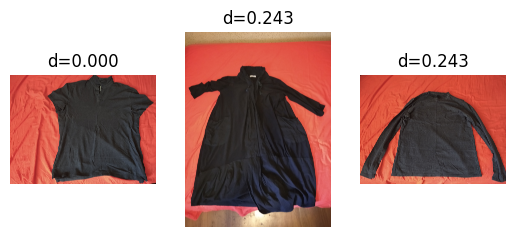

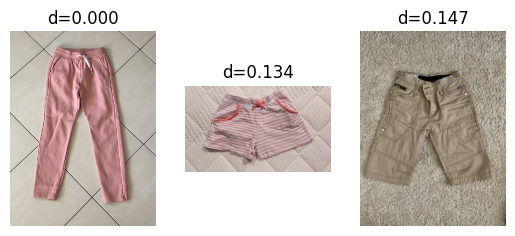

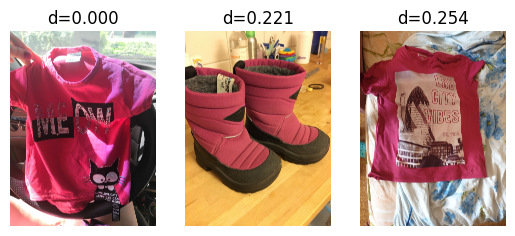

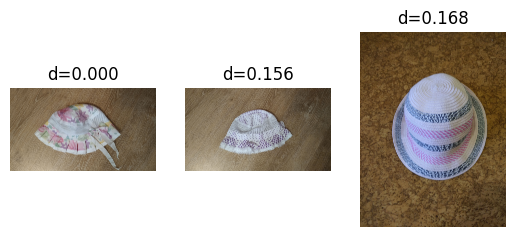

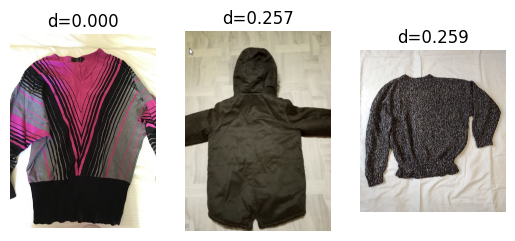

In [12]:
plot_knn_examples(embeddings, filenames)

## Color Invariance
Let's train again without color augmentation. This will force our model to
respect the colors in the images.



In [14]:
# Set color jitter and gray scale probability to 0
new_transform = SimCLRTransform(
    input_size=input_size, vf_prob=0.5, rr_prob=0.5, cj_prob=0.0, random_gray_scale=0.0
)

# let's update the transform on the training dataset
dataset_train_simclr.transform = new_transform

# then train a new model
model = SimCLRModel()
trainer = pl.Trainer(max_epochs=max_epochs, devices=1, accelerator="cpu")
trainer.fit(model, dataloader_train_simclr)

# and generate again embeddings from the test set
model.eval()
embeddings, filenames = generate_embeddings(model, dataloader_test)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.022    Total estimated model params size (MB)
c:\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
c:\Python312\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower valu

Epoch 19: 100%|██████████| 22/22 [05:14<00:00,  0.07it/s, v_num=4]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 22/22 [05:14<00:00,  0.07it/s, v_num=4]


other example



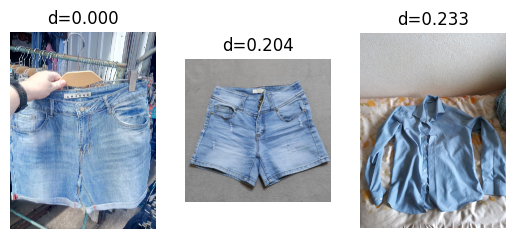

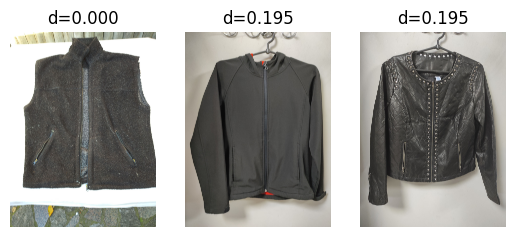

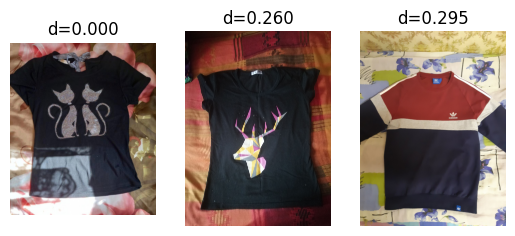

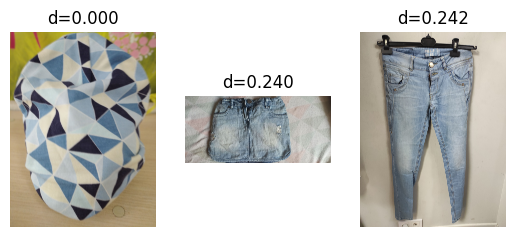

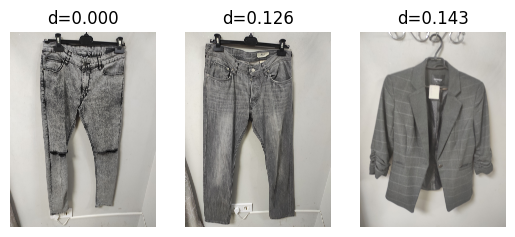

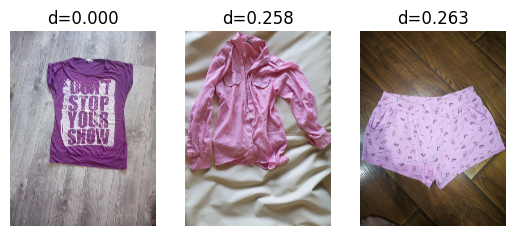

In [15]:
plot_knn_examples(embeddings, filenames)

What's next?



In [16]:
# You could use the pre-trained model and train a classifier on top.
pretrained_resnet_backbone = model.backbone

# you can also store the backbone and use it in another code
state_dict = {"resnet18_parameters": pretrained_resnet_backbone.state_dict()}
torch.save(state_dict, "model.pth")

THIS COULD BE IN A NEW FILE (e.g. inference.py)

Make sure you place the `model.pth` file in the same folder as this code



In [17]:
# load the model in a new file for inference
resnet18_new = torchvision.models.resnet18()

# note that we need to create exactly the same backbone in order to load the weights
backbone_new = nn.Sequential(*list(resnet18_new.children())[:-1])

ckpt = torch.load("model.pth")
backbone_new.load_state_dict(ckpt["resnet18_parameters"])

<All keys matched successfully>

## Next Steps

Interested in exploring other self-supervised models? Check out our other
tutorials:

- `lightly-moco-tutorial-2`
- `lightly-simsiam-tutorial-4`
- `lightly-custom-augmentation-5`
- `lightly-detectron-tutorial-6`


